In [12]:
# 📦 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [13]:
# 📂 2. Load and Prepare Data
df = pd.read_csv("E:\GARV\EXTRA\PROJECTS\Cancer Dataset.csv")
df.drop(columns=["id"], inplace=True)


In [14]:
# Save original unscaled features for later
original_df = df.copy()
X_unscaled = original_df.drop(columns=["diagnosis"])

In [32]:
# Feature selection: select top 10 features using SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_feature_mask = selector.get_support()
selected_feature_names = X.columns[selected_feature_mask].tolist()

In [33]:
# Encode target
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])


In [34]:
# Scale features
scaler_full = StandardScaler()
df.iloc[:, 1:] = scaler_full.fit_transform(df.iloc[:, 1:])

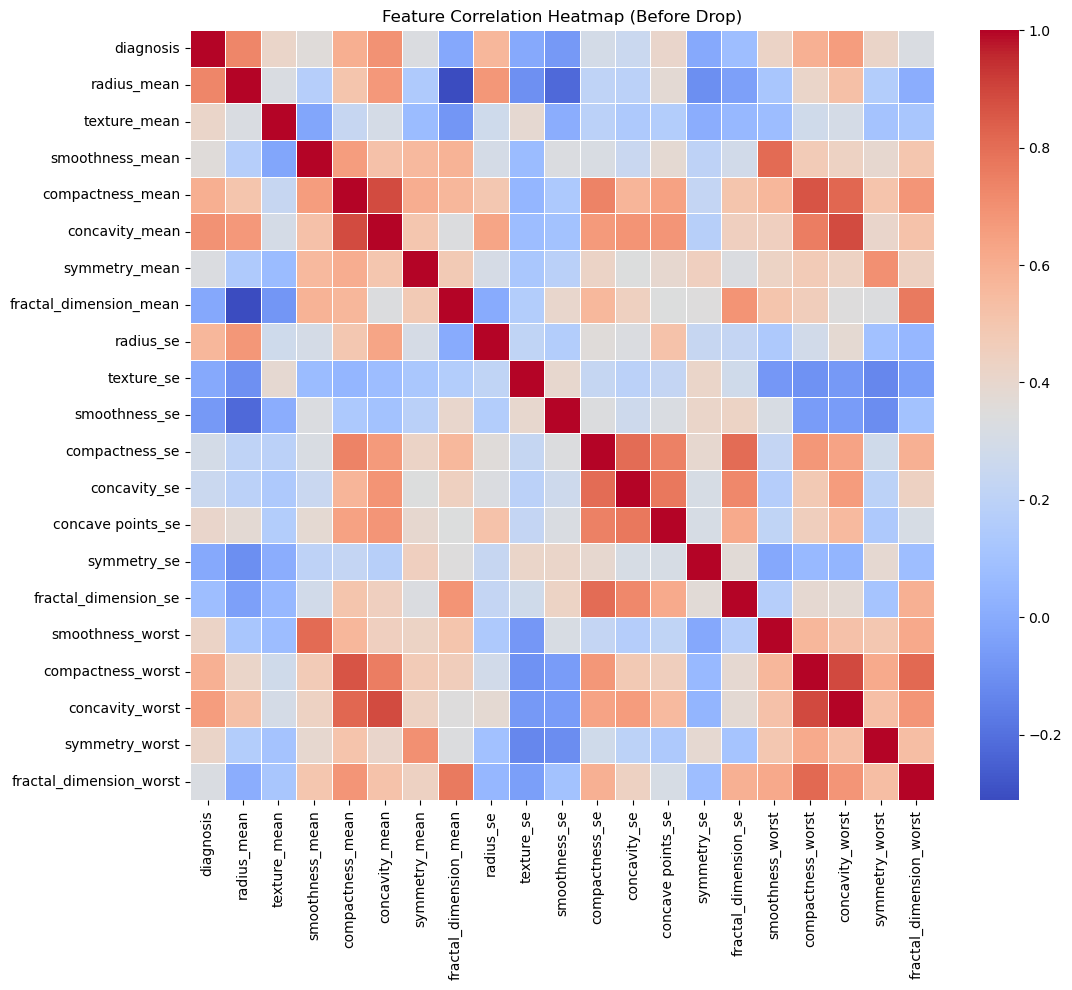

In [35]:
# 🔍 Heatmap BEFORE dropping features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap (Before Drop)")
plt.show()

In [36]:
# Drop highly correlated features
corr_matrix = df.corr()
threshold = 0.9
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            correlated_features.add(corr_matrix.columns[i])

print("\n📉 Dropped features due to correlation > 0.9:")
print(sorted(correlated_features))

df.drop(columns=correlated_features, inplace=True)


📉 Dropped features due to correlation > 0.9:
[]


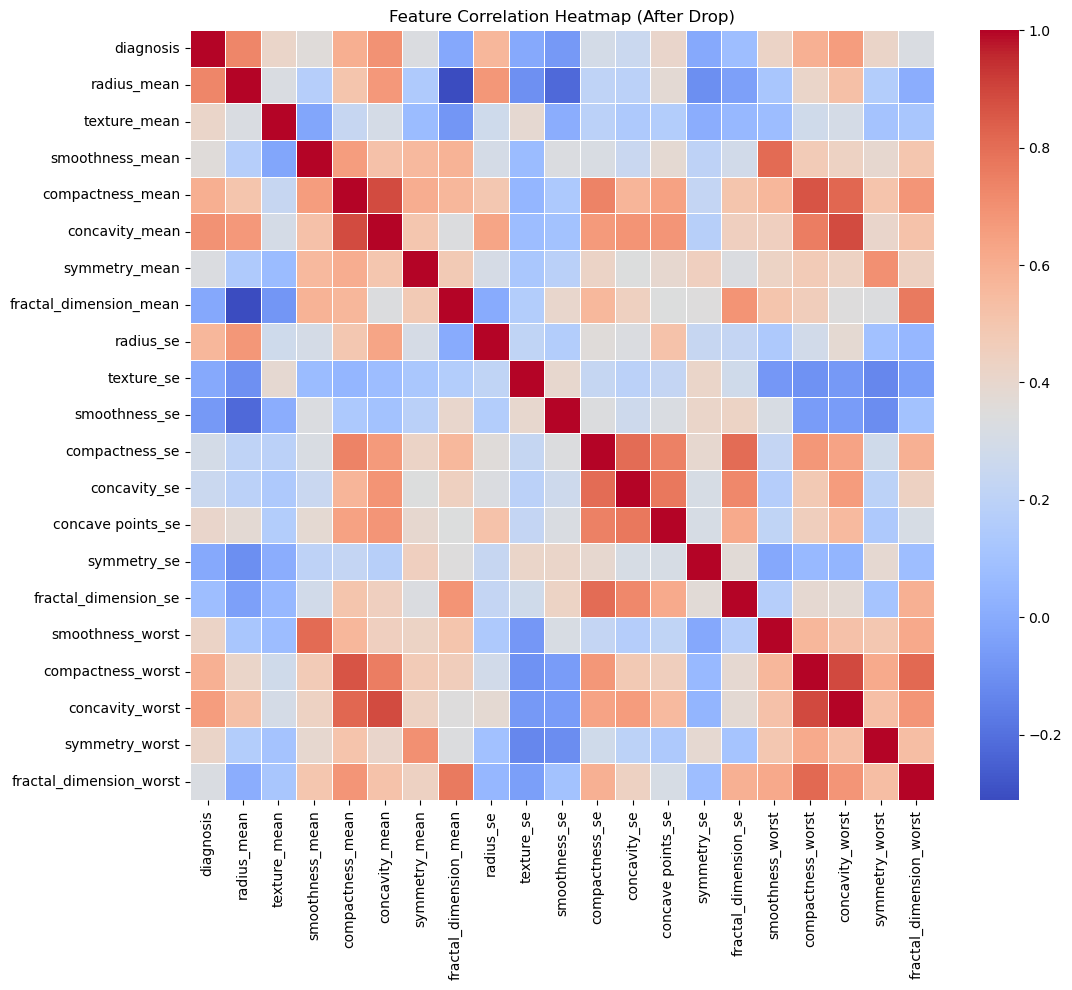

In [37]:
# Heatmap AFTER dropping features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap (After Drop)")
plt.show()

In [38]:
# 🖊️ Data Check
print("✅ Missing Values:", df.isnull().sum().sum())
print("✅ Duplicate Rows:", df.duplicated().sum())
print("✅ Class Distribution:\n", df['diagnosis'].value_counts(normalize=True))

✅ Missing Values: 0
✅ Duplicate Rows: 0
✅ Class Distribution:
 0    0.627417
1    0.372583
Name: diagnosis, dtype: float64


In [39]:
# 🎯 3. Define Features and Target
X = df.drop(columns=['diagnosis'])  # Feature matrix
y = df['diagnosis']  # Target vector

# 🔢 Train-Test Split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ⚖️ Apply SMOTE only on training data to balance classes (avoid leaking into test data)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ✅ Baseline and Threshold Tuning Evaluation
from sklearn.metrics import precision_recall_curve

def evaluate_model(X_train, y_train, X_test, y_test, model, threshold=None):
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (malignant)
    if threshold is not None:
        y_pred = (y_probs >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return acc, report

print("\n📊 Baseline Model + Threshold Tuning")
baseline_model = RandomForestClassifier(random_state=42, class_weight='balanced')
thresh_results = {}
for t in [0.3, 0.4, 0.5]:
    acc, report = evaluate_model(X_train_resampled, y_train_resampled, X_test, y_test, baseline_model, threshold=t)
    thresh_results[f"Threshold {t}"] = report['1']  # Class 1 metrics
    print(f"\n🔹 Threshold: {t}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, (baseline_model.predict_proba(X_test)[:, 1] >= t).astype(int)))



📊 Baseline Model + Threshold Tuning

🔹 Threshold: 0.3
Accuracy: 0.9561
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        72
           1       0.91      0.98      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


🔹 Threshold: 0.4
Accuracy: 0.9737
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


🔹 Threshold: 0.5
Accuracy: 0.9561
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0

In [40]:
X_selected_df = X[selected_feature_names]
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.2, random_state=42)

In [41]:
# 📈 SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [42]:
# 🧠 5. Train Multiple Models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, class_weight='balanced', kernel='rbf', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [43]:
results = {}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= 0.4).astype(int)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        'accuracy': acc,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'model': model
    }
    print(f"\n🔍 Model: {name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))


🔍 Model: Random Forest
Accuracy: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114


🔍 Model: Logistic Regression
Accuracy: 0.956140350877193
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        71
           1       0.91      0.98      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


🔍 Model: SVM
Accuracy: 0.956140350877193
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        71
           1       0.91      0.98      0.94        43

    accuracy                 

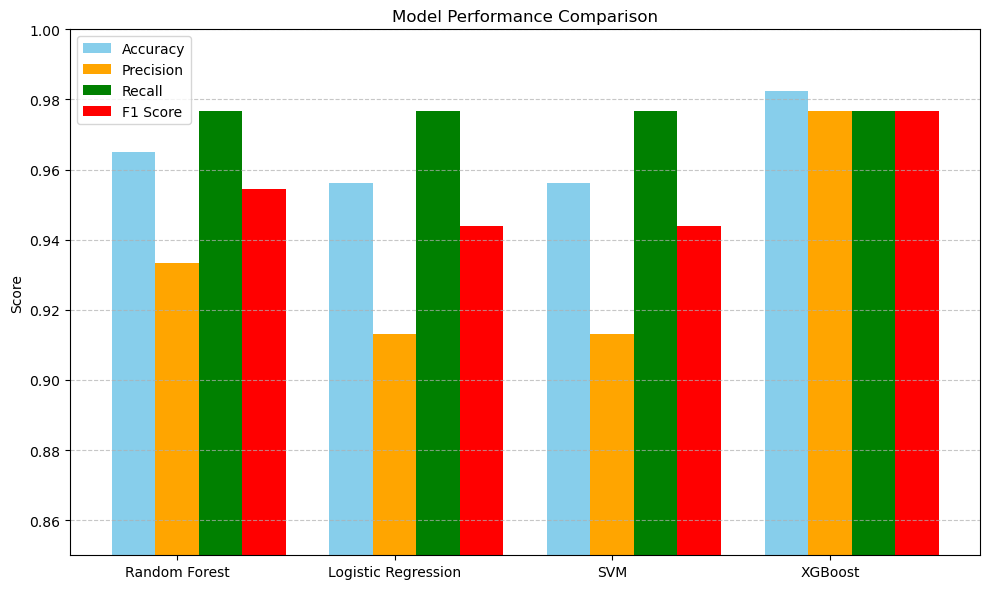

In [44]:
# 📊 6. Bar Chart Comparison
model_names = list(results.keys())
accuracy = [results[m]['accuracy'] for m in model_names]
precision = [results[m]['precision'] for m in model_names]
recall = [results[m]['recall'] for m in model_names]
f1_score = [results[m]['f1_score'] for m in model_names]

bar_width = 0.2
index = np.arange(len(model_names))

plt.figure(figsize=(10, 6))
plt.bar(index - bar_width, accuracy, width=bar_width, label='Accuracy', color='skyblue')
plt.bar(index, precision, width=bar_width, label='Precision', color='orange')
plt.bar(index + bar_width, recall, width=bar_width, label='Recall', color='green')
plt.bar(index + 2 * bar_width, f1_score, width=bar_width, label='F1 Score', color='red')

plt.xticks(index, model_names)
plt.ylabel("Score")
plt.ylim(0.85, 1.0)
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


✅ Best Model Selected: XGBoost
✅ Saved best model, top features, and matching scaler.


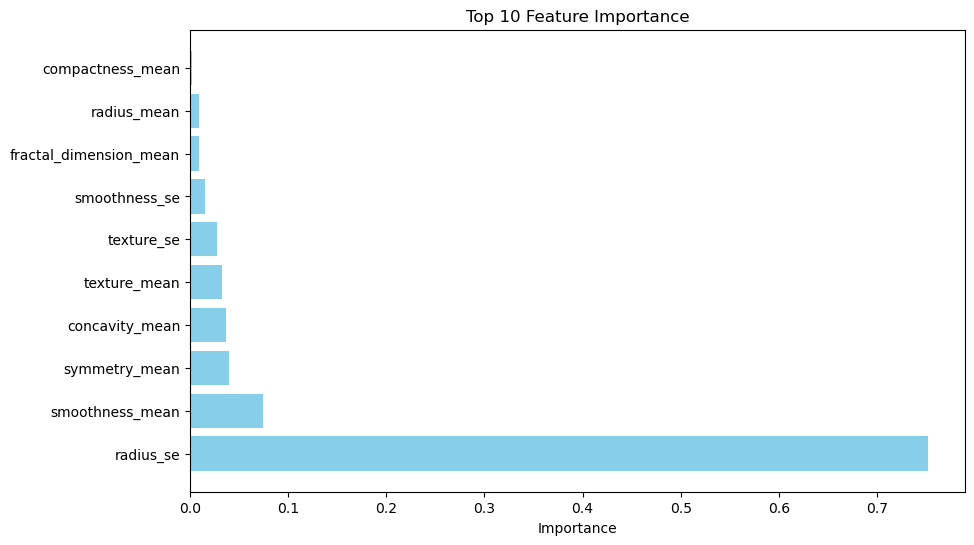

In [45]:
# 🌟 7. Save Best Model and Top 10 Features
best_model_name = max(results.items(), key=lambda x: x[1]["f1_score"])[0]
best_model = results[best_model_name]["model"]
print("\n✅ Best Model Selected:", best_model_name)

if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = X.columns[indices][:10]

    # 🔢 Create scaler for top 10 features (on UNscaled data)
    scaler_top = StandardScaler()
    scaler_top.fit(X_unscaled[top_features])

    # 💾 Save all necessary files
    joblib.dump(best_model, "breast_cancer_model.pkl")
    joblib.dump(top_features.tolist(), "selected_features.pkl")
    joblib.dump(scaler_top, "scaler.pkl")

    print("✅ Saved best model, top features, and matching scaler.")

    # 📊 Feature importance plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features[::-1], importances[indices][:10], color="skyblue")
    plt.xlabel("Importance")
    plt.title("Top 10 Feature Importance")
    plt.show()

In [46]:
# 🧪 8. Extract Scaled + Unscaled Values for App
X_test_unscaled = X_unscaled.iloc[X_test.index]  # same split as test set

sample_original = X_test_unscaled[top_features].iloc[[0]]
sample_scaled = scaler_top.transform(sample_original)

print("\n🔢 Scaled values to paste in the app:")
print(np.round(sample_scaled[0], 4).tolist())

print("\n🔁 Corresponding Unscaled (Original) values for reference:")
print(np.round(sample_original.values[0], 4).tolist())


🔢 Scaled values to paste in the app:
[0.0277, -0.4707, 0.1322, -0.0293, -0.3136, -0.1605, -0.1098, 0.4139, 0.2341, -0.0327]

🔁 Corresponding Unscaled (Original) values for reference:
[0.1058, 12.47, 0.0637, 0.007, 1.044, 18.6, 0.08, 0.1925, 0.0996, 0.3961]


In [47]:
print("\n✅ Best Model Selected:", best_model_name)



✅ Best Model Selected: XGBoost
